# GPU

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "GPU(s) física(s),", len(logical_gpus), "GPU(s) lógica(s)")
        print("Funciona")
    except RuntimeError as e:
        print(e)
else:
    print("Error")

1 GPU(s) física(s), 1 GPU(s) lógica(s)
Funciona


# Imports

In [ ]:
import os 
import requests
from zipfile import ZipFile 
import shutil #To copy the FER2013 and CK+ images to the folder
import pandas as pd #To create dataframe
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import train_test_split #Split the train, test and val data
from collections import Counter #To count the amount of labels for each generato
from keras.preprocessing.image import ImageDataGenerator #To create the generator and iterator by dataframe or directory. Also pre-processing
import numpy as np 
import matplotlib.pyplot as plt #Chart
from keras.preprocessing import image 
from keras.callbacks import ModelCheckpoint #to create a checkpoint and save each acc in each epocs that improves
from datetime import datetime #to tensorboard
from tensorflow.keras.callbacks import TensorBoard #to tensorboard
from keras.applications import InceptionResNetV2 
from keras.models import Sequential, Model 
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D 
import PIL

from keras.applications import EfficientNetB0
from keras.layers import BatchNormalization, Dropout, Dense, Conv2D, MaxPooling2D, GlobalMaxPooling2D,GlobalAveragePooling2D, Input
from keras.models import Model
from keras.regularizers import L2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
from sklearn.utils.class_weight import compute_class_weight

from keras.applications import InceptionV3
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D, Flatten,GaussianNoise, BatchNormalization, Conv2D, Input
from tensorflow.keras.optimizers import Adam,SGD
from keras.regularizers import L2
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
import math
from tqdm import tqdm
import keras_tuner as kt

In [ ]:
import random, os
import numpy as np
#import tensorflow as tf
#SET SEED
def set_seed(seed=42):
  np.random.seed(seed) 
  tf.random.set_seed(seed) 
  random.seed(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = "1"
  os.environ['TF_CUDNN_DETERMINISM'] = "1"
  os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

# Copy the images of train and test in a new folder

In [ ]:
data_dir = 'fer2013/train' #the location of the folder is defined #
filepath = [] #Define the list where all the locations of each image are to be placed
labels = [] #Define the list where all the labels are to be placed
classes = os.listdir(data_dir) #classes are listed

for classfolder in classes: #for each class
    folderclass = os.path.join(data_dir, classfolder) #get the path
    file_list = os.listdir(folderclass) #enter and list them
    for files in file_list: #for each file inside the classes
      pathfile = os.path.join(folderclass,files) #get the path
      filepath.append(pathfile)  #enter the file path in path
      labels.append(classfolder) #enter the label of file



datos = pd.DataFrame({'filepath': filepath, 'labels':labels})
# Create a dataframe that has a column called filepath, where its has the list of images locations
# Create a column called labels that will list the labels of each file

train_df, val_df = train_test_split(datos, test_size=0.2, random_state=42, stratify=datos['labels']) # split data in train set and validation set (80% - 20%) using stratify

# Output directories
output_dir = 'datosBalancingWithDataAugmentation'
new_train_folder = os.path.join(output_dir, 'train')
new_val_folder = os.path.join(output_dir, 'val')

# Create output folders if they do not exist
os.makedirs(new_train_folder, exist_ok=True)
os.makedirs(new_val_folder, exist_ok=True)

# Moving train files to the new train folder
for _, row in train_df.iterrows():
    label = row['labels']
    src_path = row['filepath']
    dst_folder = os.path.join(new_train_folder, label)
    os.makedirs(dst_folder, exist_ok=True)
    shutil.copy(src_path, dst_folder)

# Moving validation file to the new validation folder
for _, row in val_df.iterrows():
    label = row['labels']
    src_path = row['filepath']
    dst_folder = os.path.join(new_val_folder, label)
    os.makedirs(dst_folder, exist_ok=True)
    shutil.copy(src_path, dst_folder)

# Copy the 'test' folder directly without changes
test_src_folder = os.path.join('fer2013', 'test')
test_dst_folder = os.path.join(output_dir, 'test')
if os.path.exists(test_src_folder):
    shutil.copytree(test_src_folder, test_dst_folder)

In [12]:
train_df

,filepath,labels
4927,fer2013/train\fear\Training_21644135.jpg,fear
7850,fer2013/train\fear\Training_85697399.jpg,fear
3111,fer2013/train\angry\Training_80724752.jpg,angry
14742,fer2013/train\happy\Training_8750576.jpg,happy
16096,fer2013/train\neutral\Training_16088401.jpg,neutral
...,...,...
4850,fer2013/train\fear\Training_19944949.jpg,fear
3952,fer2013/train\angry\Training_99201757.jpg,angry
8732,fer2013/train\happy\Training_12347448.jpg,happy
11277,fer2013/train\happy\Training_44243624.jpg,happy


In [13]:
train_df['labels'].value_counts()

labels
happy       5772
neutral     3972
sad         3864
fear        3277
angry       3196
surprise    2537
disgust      349
Name: count, dtype: int64

In [14]:
val_df

,filepath,labels
20243,fer2013/train\neutral\Training_91712654.jpg,neutral
23266,fer2013/train\sad\Training_57347276.jpg,sad
4148,fer2013/train\disgust\Training_43986935.jpg,disgust
3108,fer2013/train\angry\Training_80694454.jpg,angry
6386,fer2013/train\fear\Training_54053151.jpg,fear
...,...,...
23056,fer2013/train\sad\Training_53510918.jpg,sad
10716,fer2013/train\happy\Training_3699660.jpg,happy
18447,fer2013/train\neutral\Training_58581958.jpg,neutral
16908,fer2013/train\neutral\Training_30460757.jpg,neutral


In [ ]:
data_dir = 'fer2013/train' #define the location of the data folder
filepath = [] #Define the list that will contain all the location of each image
labels = [] #Define th elist that will contain all the labels
classes = os.listdir(data_dir) #Labels list

for classfolder in classes: #For each class
    folderclass = os.path.join(data_dir, classfolder)  #Get the path
    file_list = os.listdir(folderclass) #Enter the data into the list
    for files in file_list: #For each file inside the classes
      pathfile = os.path.join(folderclass,files) #Get the path
      filepath.append(pathfile) #Enter the file path in filepath
      labels.append(classfolder) #Enter the file labels in labels



datos = pd.DataFrame({'filepath': filepath, 'labels':labels})
#Create a dataframe with a column called filepath, that will contain the list of image locations
# Create a column called labels, that will contain the list of labels for each file (filepath)

In [16]:
datos

,filepath,labels
0,fer2013/train\angry\Training_10118481.jpg,angry
1,fer2013/train\angry\Training_10120469.jpg,angry
2,fer2013/train\angry\Training_10131352.jpg,angry
3,fer2013/train\angry\Training_10161559.jpg,angry
4,fer2013/train\angry\Training_1021836.jpg,angry
...,...,...
28704,fer2013/train\surprise\Training_99916297.jpg,surprise
28705,fer2013/train\surprise\Training_99924420.jpg,surprise
28706,fer2013/train\surprise\Training_99937001.jpg,surprise
28707,fer2013/train\surprise\Training_99951755.jpg,surprise


In [17]:
datos['labels'].value_counts()

labels
happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
disgust      436
Name: count, dtype: int64

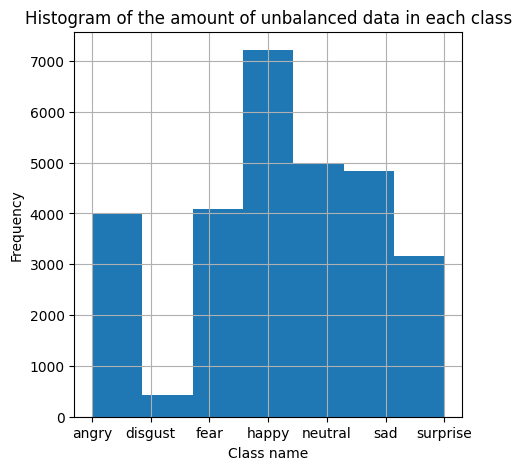

In [ ]:
plt.figure(figsize=(5,5)) #To show the number of each class
datos['labels'].hist(bins=7)
plt.xlabel('Class name')
plt.ylabel("Frequency")
plt.title("Histogram of the amount of unbalanced data in each class")
plt.show()

In [11]:
datos.describe()

,filepath,labels
count,28709,28709
unique,28709,7
top,fer2013/train\angry\Training_10118481.jpg,happy
freq,1,7215


In [12]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  28709 non-null  object
 1   labels    28709 non-null  object
dtypes: object(2)
memory usage: 448.7+ KB


# Data balancing through data augmentation in the training set

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


data_dir = 'datosBalancingWithDataAugmentation/train'

# The list of classes
classes = os.listdir(data_dir)

# Balances the data to 5,772 each class
max_images_per_class = 5772

# Data Augmentation parameters for Oversampling
datagen = ImageDataGenerator(
    rotation_range=2,  # rotation range between -2 to 2
    width_shift_range=0.02,  # Width shift range 0.02 
    height_shift_range=0.02,  # Height shift range 0.02 
    zoom_range=0.02,  # zoom range
)

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    num_images = len(os.listdir(class_dir))
    
    # Apply Data Augmentation only to minority classes
    if num_images < max_images_per_class: #If the number of images in the class is less than 5.772
        print(f"Aplicando Data Augmentation a la clase: {class_name}")
        images_needed = max_images_per_class - num_images
        print(images_needed)

    while len(os.listdir(class_dir)) < max_images_per_class: #To be applied for as long as the amount is less than 8,500
        for img_file in os.listdir(class_dir):
            if (len(os.listdir(class_dir)) == max_images_per_class): #if they are the same, let it come out
                break
            img_path = os.path.join(class_dir, img_file)
            
            # Load the image
            img = load_img(img_path)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)
            
            # Using a batch of 1 image, new images are generated with transformations and saved in the same directory
            for batch in datagen.flow(x, batch_size=1, save_to_dir=class_dir, save_prefix='aug', save_format='jpg'):
                break


Aplicando Data Augmentation a la clase: angry
2576
Aplicando Data Augmentation a la clase: disgust
5423
Aplicando Data Augmentation a la clase: fear
2495
Aplicando Data Augmentation a la clase: neutral
1800
Aplicando Data Augmentation a la clase: sad
1908
Aplicando Data Augmentation a la clase: surprise
3235


In [ ]:
data_dir = 'datosBalancingWithDataAugmentation/train' #define the location of the data folder
filepath = [] #Define the list that will contain all the location of each image
labels = [] #Define th elist that will contain all the labels
classes = os.listdir(data_dir) #Labels list

for classfolder in classes: #For each class
    folderclass = os.path.join(data_dir, classfolder) #Get the path
    file_list = os.listdir(folderclass) #Enter the data into the list
    for files in file_list: #For each file inside the classes
      pathfile = os.path.join(folderclass,files) #Get the path
      filepath.append(pathfile) #Enter the file path in filepath
      labels.append(classfolder) #Enter the file labels in labels



datos = pd.DataFrame({'filepath': filepath, 'labels':labels})
#Create a dataframe with a column called filepath, that will contain the list of image locations
# Create a column called labels, that will contain the list of labels for each file (filepath)

In [5]:
datos['labels'].value_counts()

labels
angry       5772
disgust     5772
fear        5772
happy       5772
neutral     5772
sad         5772
surprise    5772
Name: count, dtype: int64

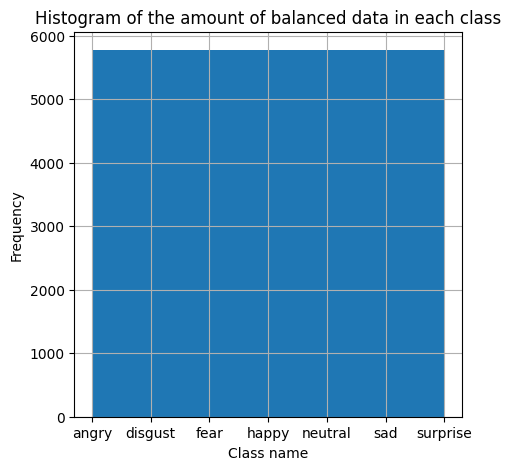

In [ ]:
plt.figure(figsize=(5,5)) #To show the new number of each class
datos['labels'].hist(bins=7)
plt.xlabel('Class name')
plt.ylabel("Frequency")
plt.title("Histogram of the amount of balanced data in each class")
plt.show()

# Data Augmentation

In [4]:
img_shape = 48
batch_size = 64

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = 'datosBalancingWithDataAugmentation/train'
val_dir = 'datosBalancingWithDataAugmentation/val'
test_dir = 'datosBalancingWithDataAugmentation/test'

train_datagen = ImageDataGenerator(
    rescale=1/255,       #normalization         
    rotation_range=8,    #rotation range between -8 to 8
    zoom_range=0.2,          #zoom range 0.2
    width_shift_range=0.1,   # width shift range     
    height_shift_range=0.1,  # height shift range         
    horizontal_flip=True,   # horizontal flip in true      
    fill_mode='nearest'                  
)

val_datagen = ImageDataGenerator(
    rescale=1/255
)

test_datagen = ImageDataGenerator(
    rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),     #48x48  
    color_mode='rgb',             #Convert the images to rgb
    class_mode='categorical',     # Apply oneHotEncoder
    batch_size=64,                 #64 batch
    seed = 42,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_shape, img_shape),   #48x48    
    color_mode='rgb',             #Convert the images to rgb
    class_mode='categorical',     # Apply oneHotEncoder
    batch_size=64,                 #64 batch
    seed = 42,           
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_shape, img_shape),       #48x48
    color_mode='rgb',             #Convert the images to rgb
    class_mode='categorical',     # Apply oneHotEncoder
    batch_size=64,                 #64 batch
    seed = 42,
    shuffle=False
)




#classes = np.array(train_generator.classes)


#class_weights = compute_class_weight(
#    class_weight='balanced',  
#    classes=np.unique(classes),  
#    y=classes  
#)


#class_weights_dict = dict(enumerate(class_weights))

#print("Class Weights Dictionary:", class_weights_dict)

Found 40404 images belonging to 7 classes.
Found 5742 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
print("Cantidad de imágenes por clase en el conjunto de entrenamiento:")
for cls, idx in train_generator.class_indices.items():
    print(f"{cls}: {sum(train_generator.classes == idx)}")

print("\nCantidad de imágenes por clase en el conjunto de validación:")
for cls, idx in val_generator.class_indices.items():
    print(f"{cls}: {sum(val_generator.classes == idx)}")

print("\nCantidad de imágenes por clase en el conjunto de prueba:")
for cls, idx in test_generator.class_indices.items():
    print(f"{cls}: {sum(test_generator.classes == idx)}")

Cantidad de imágenes por clase en el conjunto de entrenamiento:
angry: 5772
disgust: 5772
fear: 5772
happy: 5772
neutral: 5772
sad: 5772
surprise: 5772

Cantidad de imágenes por clase en el conjunto de validación:
angry: 799
disgust: 87
fear: 820
happy: 1443
neutral: 993
sad: 966
surprise: 634

Cantidad de imágenes por clase en el conjunto de prueba:
angry: 958
disgust: 111
fear: 1024
happy: 1774
neutral: 1233
sad: 1247
surprise: 831


# Models

## Model 1 CNN 66.99%

In [103]:
import tensorflow as tf
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [104]:
model_MoreData = tf.keras.Sequential([

        
        tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',input_shape=(48,48,3)),
        tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu' ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),

        
        tf.keras.layers.Conv2D(128,(5,5), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=L2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Dense(7, activation='softmax')
    ])

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate=1e-4)
model_MoreData.compile(optimizer=optimiser, #The model is created
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_MoreData.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 46, 46, 32)        896       
                                                                 
 conv2d_22 (Conv2D)          (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_14 (Bat  (None, 46, 46, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 23, 23, 64)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 23, 23, 128)      

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/test1_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/test1_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint( #To create a checkpoint when the model is improved
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/test1_MoreData/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/test1_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) #To create a graph that show the accuracy and loss curve

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [108]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

training the model

In [109]:
historytest1_MoreData = model_MoreData.fit(x = train_generator,epochs = 300,validation_data = val_generator, callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
632/632 [==============================] - ETA: 0s - loss: 9.4685 - accuracy: 0.2137
Epoch 1: val_accuracy improved from -inf to 0.25670, saving model to models2DataAugmentation/test1_MoreData/64batch\best_model_ModelPaper2_1_0.2567.h5
632/632 [==============================] - 125s 192ms/step - loss: 9.4685 - accuracy: 0.2137 - val_loss: 8.9821 - val_accuracy: 0.2567 - lr: 1.0000e-04
Epoch 2/300
632/632 [==============================] - ETA: 0s - loss: 7.9592 - accuracy: 0.2772
Epoch 2: val_accuracy improved from 0.25670 to 0.31017, saving model to models2DataAugmentation/test1_MoreData/64batch\best_model_ModelPaper2_2_0.3102.h5
632/632 [==============================] - 75s 119ms/step - loss: 7.9592 - accuracy: 0.2772 - val_loss: 7.1363 - val_accuracy: 0.3102 - lr: 1.0000e-04
Epoch 3/300
632/632 [==============================] - ETA: 0s - loss: 6.5583 - accuracy: 0.3181
Epoch 3: val_accuracy improved from 0.31017 to 0.33403, saving model to models2DataAugmentation/test1

In [133]:
model_MoreData.save('models2DataAugmentation/test1_MoreData/64batch/best_model_ModelPaper2_72_best_test.h5')

In [110]:
model_MoreData.evaluate(test_generator)

113/113 [==============================] - 9s 77ms/step - loss: 1.2211 - accuracy: 0.6700


[1.2211298942565918, 0.6699637770652771]

In [132]:
model_eval1 = tf.keras.models.load_model(r'models2DataAugmentation/test1_MoreData/64batch\best_model_ModelPaper2_71_0.6721.h5')
eval1 = model_eval1.evaluate(test_generator)
print(eval1)

113/113 [==============================] - 5s 40ms/step - loss: 1.2272 - accuracy: 0.6694
[1.2271623611450195, 0.669406533241272]


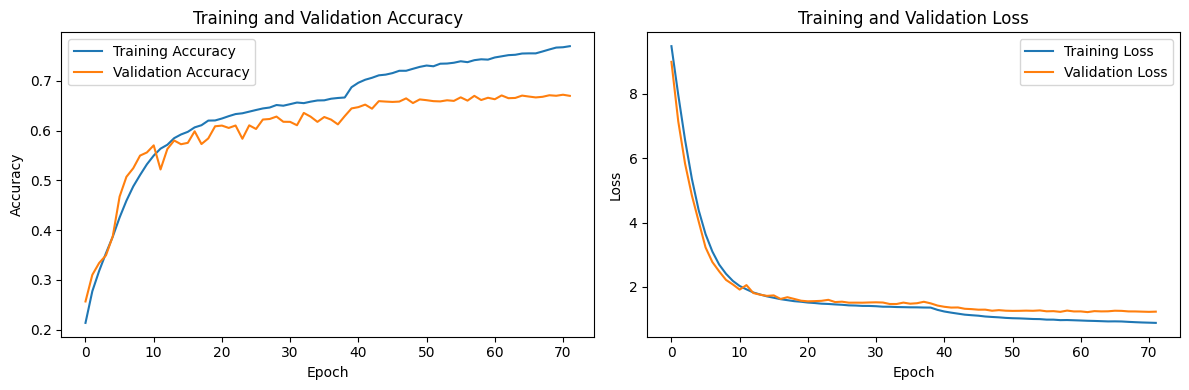

In [111]:
import matplotlib.pyplot as plt


accuracy = historytest1_MoreData.history['accuracy']
loss = historytest1_MoreData.history['loss']
val_accuracy = historytest1_MoreData.history['val_accuracy']
val_loss = historytest1_MoreData.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

model_moreData1 = tf.keras.models.load_model('models2DataAugmentation/test1_MoreData/64batch/best_model_ModelPaper2_72_best_test.h5')

y_true = test_generator.classes #Get all classes of y_test
y_pred = model_moreData1.predict(test_generator).argmax(axis=1) 

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 36s 232ms/step
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       958
           1       0.90      0.55      0.68       111
           2       0.60      0.37      0.46      1024
           3       0.82      0.90      0.86      1774
           4       0.58      0.70      0.63      1233
           5       0.55      0.55      0.55      1247
           6       0.76      0.80      0.78       831

    accuracy                           0.67      7178
   macro avg       0.69      0.64      0.65      7178
weighted avg       0.67      0.67      0.66      7178

<function confusion_matrix at 0x000001F38476ADD0>


In [8]:
model_moreData1.evaluate(test_generator)

113/113 [==============================] - 5s 42ms/step - loss: 1.2211 - accuracy: 0.6700


[1.2211298942565918, 0.6699637770652771]

## Model 2 CNN 67.62%

In [112]:
model8_MoreData = tf.keras.models.Sequential()   

model8_MoreData.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,3)))
model8_MoreData.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model8_MoreData.add(BatchNormalization())
model8_MoreData.add(MaxPooling2D(2, 2))
model8_MoreData.add(Dropout(0.3))

model8_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData.add(BatchNormalization())
model8_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData.add(Dropout(0.3))

model8_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData.add(BatchNormalization())
model8_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData.add(Dropout(0.3))

model8_MoreData.add(Flatten())
model8_MoreData.add(Dense(1024, activation='relu',kernel_regularizer=L2(0.01)))
model8_MoreData.add(Dropout(0.5))
    
model8_MoreData.add(Dense(7, activation='softmax'))


model8_MoreData.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [113]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/test8_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/test8_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/test8_MoreData/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/test8_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [114]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [115]:
historytest8_MoreData = model8_MoreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
632/632 [==============================] - ETA: 0s - loss: 20.6776 - accuracy: 0.2201
Epoch 1: val_accuracy improved from -inf to 0.31888, saving model to models2DataAugmentation/test8_MoreData/64batch\best_model_ModelPaper2_1_0.3189.h5
632/632 [==============================] - 73s 113ms/step - loss: 20.6776 - accuracy: 0.2201 - val_loss: 16.4027 - val_accuracy: 0.3189 - lr: 1.0000e-04
Epoch 2/300
632/632 [==============================] - ETA: 0s - loss: 12.6226 - accuracy: 0.3194
Epoch 2: val_accuracy did not improve from 0.31888
632/632 [==============================] - 71s 112ms/step - loss: 12.6226 - accuracy: 0.3194 - val_loss: 9.6982 - val_accuracy: 0.3175 - lr: 1.0000e-04
Epoch 3/300
632/632 [==============================] - ETA: 0s - loss: 7.6481 - accuracy: 0.3580
Epoch 3: val_accuracy improved from 0.31888 to 0.40387, saving model to models2DataAugmentation/test8_MoreData/64batch\best_model_ModelPaper2_3_0.4039.h5
632/632 [==============================] - 72s

In [134]:
model_eval2 = tf.keras.models.load_model(r'models2DataAugmentation/test8_MoreData/64batch\best_model_ModelPaper2_63_0.6735.h5')
eval1 = model_eval2.evaluate(test_generator)
print(eval1)

113/113 [==============================] - 5s 43ms/step - loss: 1.1128 - accuracy: 0.6762
[1.1128361225128174, 0.6762329339981079]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

model_moreData8_load2 = tf.keras.models.load_model(r'models2DataAugmentation/test8_MoreData/64batch\best_model_ModelPaper2_63_0.6735.h5')

y_true = test_generator.classes #Get all classes of y_test
y_pred = model_moreData8_load2.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 5s 35ms/step
              precision    recall  f1-score   support

           0       0.62      0.61      0.62       958
           1       0.76      0.58      0.66       111
           2       0.56      0.41      0.47      1024
           3       0.85      0.88      0.87      1774
           4       0.59      0.69      0.64      1233
           5       0.56      0.57      0.57      1247
           6       0.77      0.79      0.78       831

    accuracy                           0.68      7178
   macro avg       0.67      0.65      0.66      7178
weighted avg       0.67      0.68      0.67      7178

<function confusion_matrix at 0x000001F38476ADD0>


In [116]:
model8_MoreData.evaluate(test_generator)

113/113 [==============================] - 6s 53ms/step - loss: 1.1128 - accuracy: 0.6762


[1.1128361225128174, 0.6762329339981079]

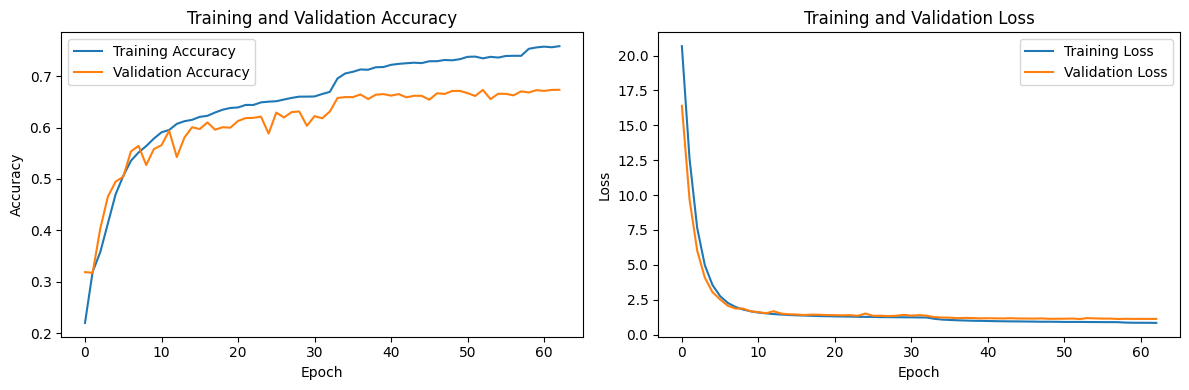

In [117]:
import matplotlib.pyplot as plt


accuracy = historytest8_MoreData.history['accuracy']
loss = historytest8_MoreData.history['loss']
val_accuracy = historytest8_MoreData.history['val_accuracy']
val_loss = historytest8_MoreData.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model 3 CNN 66.03%

In [118]:
model6_MoreData = tf.keras.models.Sequential()   

model6_MoreData.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,3)))
model6_MoreData.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model6_MoreData.add(BatchNormalization())
model6_MoreData.add(MaxPooling2D(2, 2))
model6_MoreData.add(Dropout(0.3))

model6_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model6_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model6_MoreData.add(BatchNormalization())
model6_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model6_MoreData.add(Dropout(0.3))

model6_MoreData.add(Flatten())
model6_MoreData.add(Dense(1024, activation='relu',kernel_regularizer=L2(0.01)))
model6_MoreData.add(Dropout(0.5))
    
model6_MoreData.add(Dense(7, activation='softmax'))

model6_MoreData.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [119]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/test6_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/test6_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/test6_MoreData/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/test6_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [120]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [121]:
historytest6_MoreData = model6_MoreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
632/632 [==============================] - ETA: 0s - loss: 17.1165 - accuracy: 0.2348
Epoch 1: val_accuracy improved from -inf to 0.34222, saving model to models2DataAugmentation/test6_MoreData/64batch\best_model_ModelPaper2_1_0.3422.h5
632/632 [==============================] - 92s 145ms/step - loss: 17.1165 - accuracy: 0.2348 - val_loss: 10.2075 - val_accuracy: 0.3422 - lr: 1.0000e-04
Epoch 2/300
632/632 [==============================] - ETA: 0s - loss: 6.8566 - accuracy: 0.3175
Epoch 2: val_accuracy improved from 0.34222 to 0.38558, saving model to models2DataAugmentation/test6_MoreData/64batch\best_model_ModelPaper2_2_0.3856.h5
632/632 [==============================] - 99s 157ms/step - loss: 6.8566 - accuracy: 0.3175 - val_loss: 4.5744 - val_accuracy: 0.3856 - lr: 1.0000e-04
Epoch 3/300
632/632 [==============================] - ETA: 0s - loss: 3.7184 - accuracy: 0.3613
Epoch 3: val_accuracy did not improve from 0.38558
632/632 [==============================] - 77s 1

In [122]:
model6_MoreData.evaluate(test_generator)

113/113 [==============================] - 10s 83ms/step - loss: 1.1081 - accuracy: 0.6594


[1.108148455619812, 0.6593758463859558]

In [131]:
model6_MoreData1 = tf.keras.models.load_model(r'models2DataAugmentation/test6_MoreData/64batch\best_model_ModelPaper2_117_0.6609.h5')
eval = model6_MoreData1.evaluate(test_generator)
print(eval)

113/113 [==============================] - 4s 36ms/step - loss: 1.1128 - accuracy: 0.6604
[1.1128302812576294, 0.6603510975837708]


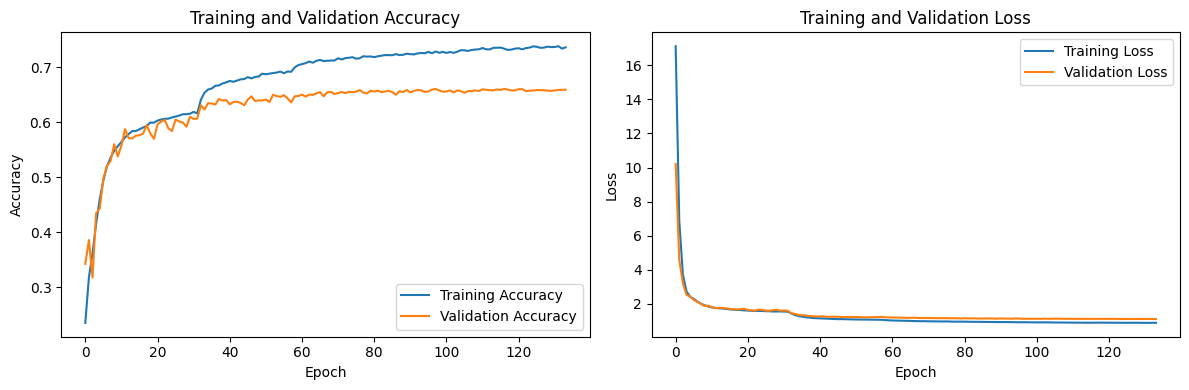

In [123]:
import matplotlib.pyplot as plt


accuracy = historytest6_MoreData.history['accuracy']
loss = historytest6_MoreData.history['loss']
val_accuracy = historytest6_MoreData.history['val_accuracy']
val_loss = historytest6_MoreData.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model 4 VGG19 66.03%

In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50V2, VGG19
from keras.regularizers import l2
from keras.optimizers import Adamax



input_shape = (48, 48, 3)

base_model = VGG19(include_top=False, weights='imagenet', input_shape=input_shape) #Pre-training model with imagenet weights

model3_MoreData = Sequential([
                    base_model,
                    BatchNormalization(),
                    GlobalAveragePooling2D(),
                    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
                    Dropout(0.4),
                    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
                    Dropout(0.4),
                    Dense(7, activation='softmax')
                  ])

optimizer = Adamax(learning_rate=1e-4)

model3_MoreData.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model3_MoreData.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 batch_normalization_25 (Bat  (None, 1, 1, 512)        2048      
 chNormalization)                                                
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dropout_30 (Dropout)        (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 128)              

In [125]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/test3_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/test3_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/test3_MoreData/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/test3_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [126]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [127]:
historytest3_MoreData = model3_MoreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator,
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
632/632 [==============================] - ETA: 0s - loss: 2.2267 - accuracy: 0.3080
Epoch 1: val_accuracy improved from -inf to 0.33386, saving model to models2DataAugmentation/test3_MoreData/64batch\best_model_ModelPaper2_1_0.3339.h5
632/632 [==============================] - 99s 149ms/step - loss: 2.2267 - accuracy: 0.3080 - val_loss: 2.0804 - val_accuracy: 0.3339 - lr: 1.0000e-04
Epoch 2/300
632/632 [==============================] - ETA: 0s - loss: 1.8201 - accuracy: 0.4654
Epoch 2: val_accuracy improved from 0.33386 to 0.41205, saving model to models2DataAugmentation/test3_MoreData/64batch\best_model_ModelPaper2_2_0.4121.h5
632/632 [==============================] - 177s 281ms/step - loss: 1.8201 - accuracy: 0.4654 - val_loss: 1.9232 - val_accuracy: 0.4121 - lr: 1.0000e-04
Epoch 3/300
632/632 [==============================] - ETA: 0s - loss: 1.6156 - accuracy: 0.5262
Epoch 3: val_accuracy improved from 0.41205 to 0.46047, saving model to models2DataAugmentation/test3

In [130]:
model3_MoreData = tf.keras.models.load_model(r'models2DataAugmentation/test3_MoreData/64batch\best_model_ModelPaper2_23_0.6620.h5')
eval = model3_MoreData.evaluate(test_generator)
print(eval)

113/113 [==============================] - 26s 216ms/step - loss: 1.2358 - accuracy: 0.6604
[1.2357673645019531, 0.6603510975837708]


In [10]:
from sklearn.metrics import classification_report, confusion_matrix

model_moreData8_load3 = tf.keras.models.load_model(r'models2DataAugmentation\test3_MoreData\64batch\best_model_ModelPaper2_23_0.6620.h5')

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model_moreData8_load3.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 6s 44ms/step
              precision    recall  f1-score   support

           0       0.61      0.58      0.60       958
           1       0.91      0.55      0.69       111
           2       0.59      0.41      0.48      1024
           3       0.81      0.91      0.85      1774
           4       0.58      0.66      0.61      1233
           5       0.50      0.55      0.53      1247
           6       0.83      0.72      0.77       831

    accuracy                           0.66      7178
   macro avg       0.69      0.62      0.65      7178
weighted avg       0.66      0.66      0.66      7178

<function confusion_matrix at 0x000001F38476ADD0>


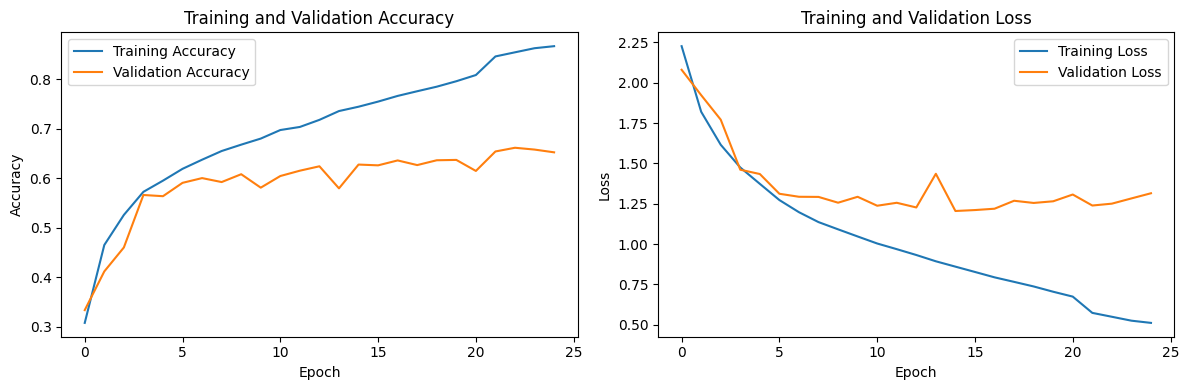

In [129]:
import matplotlib.pyplot as plt


accuracy = historytest3_MoreData.history['accuracy']
loss = historytest3_MoreData.history['loss']
val_accuracy = historytest3_MoreData.history['val_accuracy']
val_loss = historytest3_MoreData.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model 5 ResNet50V2 53.99%

In [ ]:
from keras.applications import ResNet50V2
ResNet =ResNet50V2(input_shape=(48, 48, 3), include_top=False, weights='imagenet') #Pre-training model with imagenet weights
ResNet.summary()

ResNet.trainable=True

for layer in ResNet.layers[:-50]:
    layer.trainable = False

ResNet.summary()

x = Flatten()(ResNet.output)


x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  


output = Dense(7, activation='softmax', kernel_initializer='he_normal')(x)

model4 = Model(inputs=ResNet.input, outputs=output)

model4.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model4.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 26, 26, 64)   0           ['conv1_conv[0][0]']             
                                                                                         

In [28]:
from keras.callbacks import ReduceLROnPlateau


#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/test4_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/test4_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/test4_MoreData/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/test4_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [30]:
historytest3_MoreData4 = model4.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator,
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
632/632 [==============================] - ETA: 0s - loss: 1.8233 - accuracy: 0.3149
Epoch 1: val_accuracy improved from -inf to 0.40195, saving model to models2DataAugmentation/test4_MoreData/64batch\best_model_ModelPaper2_1_0.4020.h5
632/632 [==============================] - 127s 168ms/step - loss: 1.8233 - accuracy: 0.3149 - val_loss: 1.5382 - val_accuracy: 0.4020 - lr: 1.0000e-04
Epoch 2/300
632/632 [==============================] - ETA: 0s - loss: 1.4657 - accuracy: 0.4408
Epoch 2: val_accuracy improved from 0.40195 to 0.45925, saving model to models2DataAugmentation/test4_MoreData/64batch\best_model_ModelPaper2_2_0.4592.h5
632/632 [==============================] - 90s 142ms/step - loss: 1.4657 - accuracy: 0.4408 - val_loss: 1.4199 - val_accuracy: 0.4592 - lr: 1.0000e-04
Epoch 3/300
632/632 [==============================] - ETA: 0s - loss: 1.3379 - accuracy: 0.4917
Epoch 3: val_accuracy improved from 0.45925 to 0.48659, saving model to models2DataAugmentation/test4

In [35]:
model4.evaluate(test_generator)

113/113 [==============================] - 27s 238ms/step - loss: 1.2328 - accuracy: 0.5400


[1.2328038215637207, 0.5399832725524902]

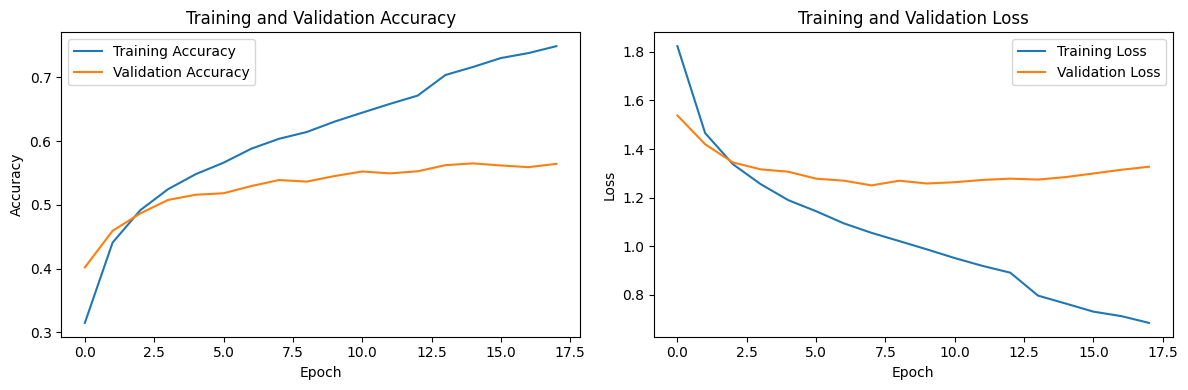

In [38]:
import matplotlib.pyplot as plt


accuracy = historytest3_MoreData4.history['accuracy']
loss = historytest3_MoreData4.history['loss']
val_accuracy = historytest3_MoreData4.history['val_accuracy']
val_loss = historytest3_MoreData4.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model 6 CNN 65.82%

In [32]:
from keras.regularizers import L2
model15 = Sequential()

model15.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 3)))
model15.add(BatchNormalization())
model15.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(MaxPooling2D(pool_size=(2, 2)))
model15.add(Dropout(0.3))

model15.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(MaxPooling2D(pool_size=(2, 2)))
model15.add(Dropout(0.3))

model15.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(MaxPooling2D(pool_size=(2, 2)))
model15.add(Dropout(0.3))

model15.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(MaxPooling2D(pool_size=(2, 2)))
model15.add(Dropout(0.3))

model15.add(Flatten())
model15.add(Dense(1024, activation='relu', kernel_regularizer=L2(0.01)))
model15.add(Dropout(0.5))
model15.add(Dense(7, activation='softmax'))

model15.compile(optimizer=Adam(learning_rate=1e-4), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

model15.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_9 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                      

In [33]:
from keras.callbacks import ReduceLROnPlateau


#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/test5_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/test5_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/test5_MoreData/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/test5_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [34]:
historytest3_MoreData5 = model15.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator,
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
632/632 [==============================] - ETA: 0s - loss: 14.9802 - accuracy: 0.2104
Epoch 1: val_accuracy improved from -inf to 0.25792, saving model to models2DataAugmentation/test5_MoreData/64batch\best_model_ModelPaper2_1_0.2579.h5
632/632 [==============================] - 192s 300ms/step - loss: 14.9802 - accuracy: 0.2104 - val_loss: 11.0665 - val_accuracy: 0.2579 - lr: 1.0000e-04
Epoch 2/300
632/632 [==============================] - ETA: 0s - loss: 7.4794 - accuracy: 0.3088
Epoch 2: val_accuracy improved from 0.25792 to 0.32062, saving model to models2DataAugmentation/test5_MoreData/64batch\best_model_ModelPaper2_2_0.3206.h5
632/632 [==============================] - 90s 142ms/step - loss: 7.4794 - accuracy: 0.3088 - val_loss: 5.1165 - val_accuracy: 0.3206 - lr: 1.0000e-04
Epoch 3/300
632/632 [==============================] - ETA: 0s - loss: 3.7403 - accuracy: 0.3586
Epoch 3: val_accuracy improved from 0.32062 to 0.35650, saving model to models2DataAugmentation/te

In [39]:
model15_load =tf.keras.models.load_model(r'models2DataAugmentation/test5_MoreData/64batch\best_model_ModelPaper2_29_0.6630.h5')
model15_load.evaluate(test_generator)

113/113 [==============================] - 5s 42ms/step - loss: 1.0096 - accuracy: 0.6583


[1.0095502138137817, 0.6582613587379456]

In [37]:
model15.evaluate(test_generator)

113/113 [==============================] - 5s 45ms/step - loss: 1.0067 - accuracy: 0.6534


[1.0067260265350342, 0.65338534116745]

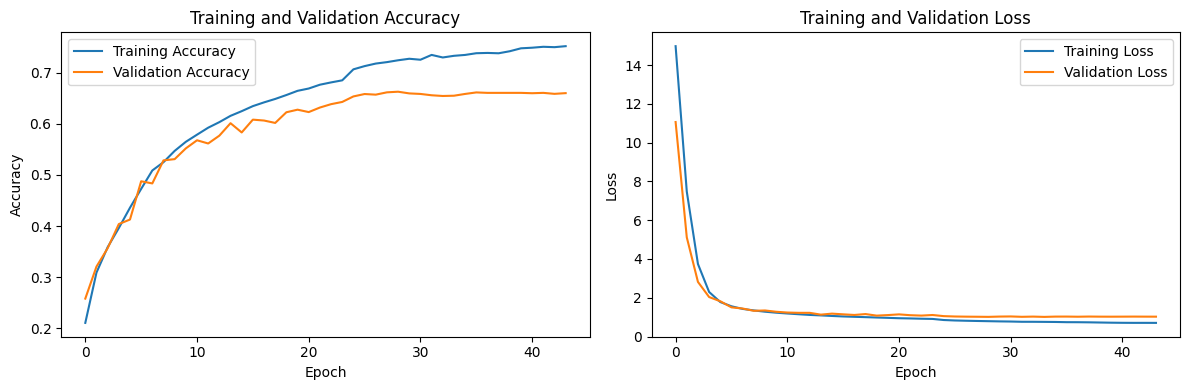

In [36]:
import matplotlib.pyplot as plt


accuracy = historytest3_MoreData5.history['accuracy']
loss = historytest3_MoreData5.history['loss']
val_accuracy = historytest3_MoreData5.history['val_accuracy']
val_loss = historytest3_MoreData5.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model 7 CNN 67.53%

In [40]:
model13 = tf.keras.models.Sequential()

model13.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 3)))
model13.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model13.add(BatchNormalization())
model13.add(MaxPooling2D(2, 2))
model13.add(Dropout(0.3))

model13.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model13.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model13.add(BatchNormalization())
model13.add(MaxPooling2D(pool_size=(2, 2)))
model13.add(Dropout(0.3))

model13.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model13.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model13.add(BatchNormalization())
model13.add(MaxPooling2D(pool_size=(2, 2)))
model13.add(Dropout(0.3))

model13.add(Flatten())
model13.add(Dense(2048, activation='relu', kernel_regularizer=L2(0.01)))
model13.add(Dropout(0.5))
model13.add(Dense(1024, activation='relu', kernel_regularizer=L2(0.01)))
model13.add(Dropout(0.5))

model13.add(Dense(7, activation='softmax'))

model13.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [41]:
from keras.callbacks import ReduceLROnPlateau


#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/test6_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/test6_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/test6_MoreData/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/test6_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [42]:
historytest3_MoreData6 = model13.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator,
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
632/632 [==============================] - ETA: 0s - loss: 38.7145 - accuracy: 0.1939
Epoch 1: val_accuracy improved from -inf to 0.27447, saving model to models2DataAugmentation/test6_MoreData/64batch\best_model_ModelPaper2_1_0.2745.h5
632/632 [==============================] - 176s 275ms/step - loss: 38.7145 - accuracy: 0.1939 - val_loss: 27.5586 - val_accuracy: 0.2745 - lr: 1.0000e-04
Epoch 2/300
632/632 [==============================] - ETA: 0s - loss: 19.6670 - accuracy: 0.2823
Epoch 2: val_accuracy improved from 0.27447 to 0.30843, saving model to models2DataAugmentation/test6_MoreData/64batch\best_model_ModelPaper2_2_0.3084.h5
632/632 [==============================] - 72s 114ms/step - loss: 19.6670 - accuracy: 0.2823 - val_loss: 13.4568 - val_accuracy: 0.3084 - lr: 1.0000e-04
Epoch 3/300
632/632 [==============================] - ETA: 0s - loss: 9.8696 - accuracy: 0.3521
Epoch 3: val_accuracy improved from 0.30843 to 0.38488, saving model to models2DataAugmentation

In [46]:
model13_load = tf.keras.models.load_model(r'models2DataAugmentation/test6_MoreData/64batch\best_model_ModelPaper2_69_0.6759.h5')
print(model13_load.evaluate(test_generator))

113/113 [==============================] - 5s 40ms/step - loss: 1.1241 - accuracy: 0.6754
[1.1241286993026733, 0.6753970384597778]


In [43]:
model13.evaluate(test_generator)

113/113 [==============================] - 10s 86ms/step - loss: 1.1201 - accuracy: 0.6743


[1.1201196908950806, 0.6742825508117676]

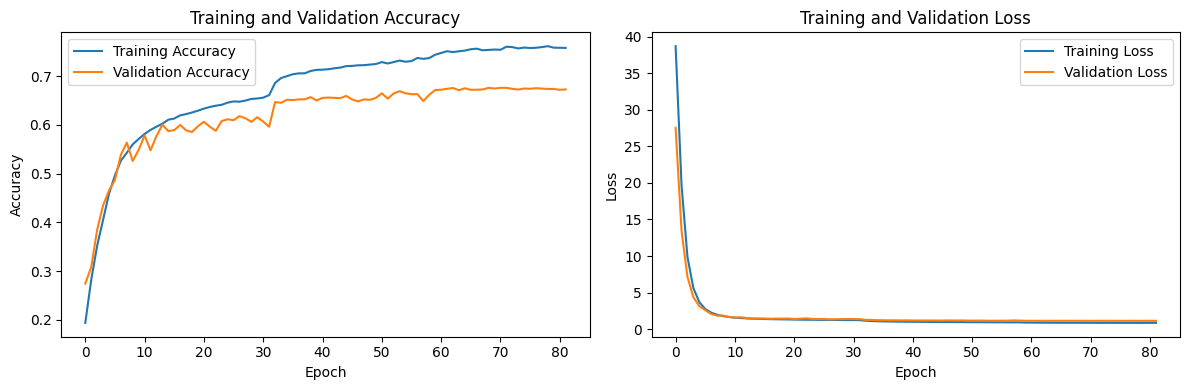

In [44]:
import matplotlib.pyplot as plt


accuracy = historytest3_MoreData6.history['accuracy']
loss = historytest3_MoreData6.history['loss']
val_accuracy = historytest3_MoreData6.history['val_accuracy']
val_loss = historytest3_MoreData6.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model Keras tunner 67.86%

In [ ]:
def build_model(hp):
    input_layer = tf.keras.layers.Input(shape=(48, 48, 3))
    x = input_layer
    
    num_layers = hp.Int('num_layers', min_value=2, max_value=6)
    for i in range(num_layers): #for each layer
        num_filters1 = hp.Int(f'conv_{i}_units1', min_value=32, max_value=512, step=32) #Creates a hidden layer that has between 32 to 512 filters
        x = tf.keras.layers.Conv2D(filters=num_filters1, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(x) #With ReLU and padding = same
        num_filters2 = hp.Int(f'conv_{i}_units2', min_value=32, max_value=512, step=32) #Creates a hidden layer that has between 32 to 512 filters
        x = tf.keras.layers.Conv2D(filters=num_filters2, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(x) #With ReLU and padding = same
        x = BatchNormalization()(x)
        
        # Conditional verification for MaxPooling2D
        if x.shape[1] > 1 and x.shape[2] > 1:
            x = MaxPooling2D(pool_size=(2, 2))(x)
        
        x = Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1))(x) #search the optimal learning rate

    x = tf.keras.layers.Flatten()(x)
    x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(7, activation="softmax")(x)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=Adam(1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [ ]:
tuner = kt.BayesianOptimization( #Configuration by Bayesian optimization for all possibilities.
    build_model, 
    objective='val_accuracy',
    max_trials=5,  # Max number of tests 
    executions_per_trial=3,
    directory='TunerBayesianDirectoryBalancing',
    project_name='KerasTunerBalancing'
)

In [10]:
from keras.callbacks import ReduceLROnPlateau

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/testKerastunnerBalancing/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/testKerastunnerBalancing/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/testKerastunnerBalancing/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/testKerastunnerBalancing/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [ ]:
tuner.search( #Search by Bayesian optimization for all possibilities.
    x=train_generator,
    epochs=300,  
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint, tensorboard_callback, reduce_lr],
    shuffle=True
)

Trial 5 Complete [18h 03m 32s]
val_accuracy: 0.6746197541554769

Best val_accuracy So Far: 0.6769998868306478
Total elapsed time: 2d 12h 47m 43s


In [ ]:
print(tuner.get_best_models()[0].summary())
print(tuner.get_best_hyperparameters()[0].values)

model = tuner.get_best_models(num_models=1)[0] #Get the best model found in the tests
print (model.summary())
model.compile(optimizer=Adam(1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 448)       12544     
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 224)       903392    
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 224)      896       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 224)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 224)       0     

### Creation the keras tunner model 1

In [8]:
input = Input(shape=(48,48,3))

x = tf.keras.layers.Conv2D(filters=448, kernel_size=(3,3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(input)
x = tf.keras.layers.Conv2D(filters=224, kernel_size=(3,3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.4)(x)

x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(x)
x = tf.keras.layers.Conv2D(filters=288, kernel_size=(3,3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.1)(x)

x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(x)
x = tf.keras.layers.Conv2D(filters=416, kernel_size=(3,3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.4)(x)

x = tf.keras.layers.Conv2D(filters=96, kernel_size=(3,3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(x)
x = tf.keras.layers.Conv2D(filters=224, kernel_size=(3,3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.30000000000000004)(x)

x = Flatten()(x)

x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(7, activation="softmax")(x)

model1kerastunner = Model(inputs=input, outputs=output)

model1kerastunner.compile(optimizer=Adam(1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])


model1kerastunner.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 48, 48, 448)       12544     
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 224)       903392    
                                                                 
 batch_normalization_4 (Batc  (None, 48, 48, 224)      896       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 224)      0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 224)       0   

In [9]:
from keras.callbacks import ReduceLROnPlateau

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/KerastunnerBalancing/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/KerastunnerBalancing/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/KerastunnerBalancing/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/KerastunnerBalancing/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [10]:
HistoryTunner1 = model1kerastunner.fit(
    x=train_generator,
    epochs=300,  
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint, tensorboard_callback, reduce_lr],
    shuffle=True
)

Epoch 1/300
632/632 [==============================] - ETA: 0s - loss: 11.0547 - accuracy: 0.1850
Epoch 1: val_accuracy improved from -inf to 0.25096, saving model to models2DataAugmentation/KerastunnerBalancing/64batch\best_model_ModelPaper2_1_0.2510.h5
632/632 [==============================] - 167s 251ms/step - loss: 11.0547 - accuracy: 0.1850 - val_loss: 10.1287 - val_accuracy: 0.2510 - lr: 1.0000e-04
Epoch 2/300
632/632 [==============================] - ETA: 0s - loss: 8.7246 - accuracy: 0.2350
Epoch 2: val_accuracy improved from 0.25096 to 0.29693, saving model to models2DataAugmentation/KerastunnerBalancing/64batch\best_model_ModelPaper2_2_0.2969.h5
632/632 [==============================] - 174s 276ms/step - loss: 8.7246 - accuracy: 0.2350 - val_loss: 7.8589 - val_accuracy: 0.2969 - lr: 1.0000e-04
Epoch 3/300
632/632 [==============================] - ETA: 0s - loss: 6.9731 - accuracy: 0.2798
Epoch 3: val_accuracy improved from 0.29693 to 0.30042, saving model to models2DataAu

113/113 [==============================] - 14s 122ms/step - loss: 1.1096 - accuracy: 0.6645
[1.1095585823059082, 0.6645305156707764]


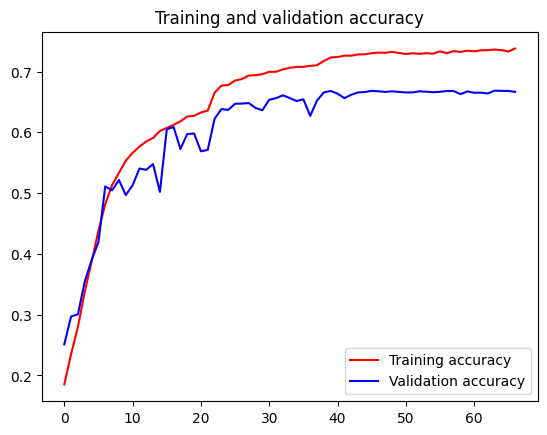

<Figure size 640x480 with 0 Axes>

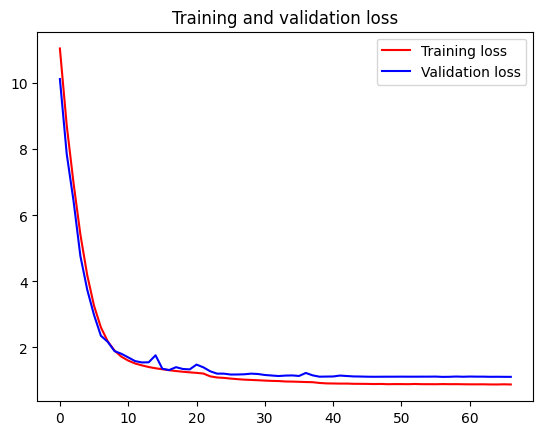

In [11]:
print(model1kerastunner.evaluate(test_generator))

import matplotlib.pyplot as plt
accuracy = HistoryTunner1.history['accuracy']
val_acc = HistoryTunner1.history['val_accuracy']
loss = HistoryTunner1.history['loss']
val_loss = HistoryTunner1.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

### Creation the keras tunner model 2

In [14]:
input = Input(shape=(48,48,3))

x = tf.keras.layers.Conv2D(filters=448, kernel_size=(3,3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(input)
x = tf.keras.layers.Conv2D(filters=224, kernel_size=(3,3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.4)(x)

x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(x)
x = tf.keras.layers.Conv2D(filters=288, kernel_size=(3,3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.1)(x)

x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(x)
x = tf.keras.layers.Conv2D(filters=416, kernel_size=(3,3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.4)(x)

x = tf.keras.layers.Conv2D(filters=96, kernel_size=(3,3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(x)
x = tf.keras.layers.Conv2D(filters=224, kernel_size=(3,3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.30000000000000004)(x)

x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(x)
x = tf.keras.layers.Conv2D(filters=416, kernel_size=(3,3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.1)(x)

x = tf.keras.layers.Conv2D(filters=480, kernel_size=(3,3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(x)
x = tf.keras.layers.Conv2D(filters=160, kernel_size=(3,3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Flatten()(x)

x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(7, activation="softmax")(x)

model2kerastunner = Model(inputs=input, outputs=output)

model2kerastunner.compile(optimizer=Adam(1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])


model2kerastunner.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 48, 48, 448)       12544     
                                                                 
 conv2d_40 (Conv2D)          (None, 48, 48, 224)       903392    
                                                                 
 batch_normalization_20 (Bat  (None, 48, 48, 224)      896       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 24, 24, 224)      0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 24, 24, 224)       0   

In [15]:
from keras.callbacks import ReduceLROnPlateau

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/KerastunnerBalancing2/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/KerastunnerBalancing2/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/KerastunnerBalancing2/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/KerastunnerBalancing2/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [16]:
HistoryTunner2 = model2kerastunner.fit(
    x=train_generator,
    epochs=300,  
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint, tensorboard_callback, reduce_lr],
    shuffle=True
)

Epoch 1/300
632/632 [==============================] - ETA: 0s - loss: 13.7862 - accuracy: 0.1790
Epoch 1: val_accuracy improved from -inf to 0.25131, saving model to models2DataAugmentation/KerastunnerBalancing2/64batch\best_model_ModelPaper2_1_0.2513.h5
632/632 [==============================] - 158s 246ms/step - loss: 13.7862 - accuracy: 0.1790 - val_loss: 10.9699 - val_accuracy: 0.2513 - lr: 1.0000e-04
Epoch 2/300
632/632 [==============================] - ETA: 0s - loss: 9.4466 - accuracy: 0.2360
Epoch 2: val_accuracy improved from 0.25131 to 0.25862, saving model to models2DataAugmentation/KerastunnerBalancing2/64batch\best_model_ModelPaper2_2_0.2586.h5
632/632 [==============================] - 155s 246ms/step - loss: 9.4466 - accuracy: 0.2360 - val_loss: 7.9638 - val_accuracy: 0.2586 - lr: 1.0000e-04
Epoch 3/300
632/632 [==============================] - ETA: 0s - loss: 6.7242 - accuracy: 0.3241
Epoch 3: val_accuracy improved from 0.25862 to 0.28126, saving model to models2Data

In [19]:
model2kerastunner_load = tf.keras.models.load_model(r'models2DataAugmentation\KerastunnerBalancing2\64batch\best_model_ModelPaper2_57_0.6813.h5')
model2kerastunner_load.evaluate(test_generator)

113/113 [==============================] - 13s 109ms/step - loss: 1.1276 - accuracy: 0.6772


[1.1275570392608643, 0.6772081255912781]

113/113 [==============================] - 14s 120ms/step - loss: 1.1268 - accuracy: 0.6786
[1.1267626285552979, 0.6786012649536133]


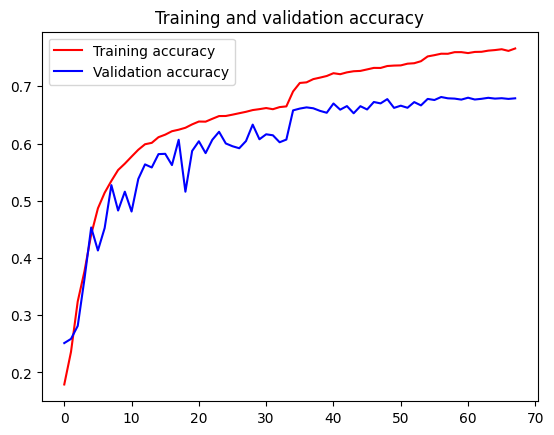

<Figure size 640x480 with 0 Axes>

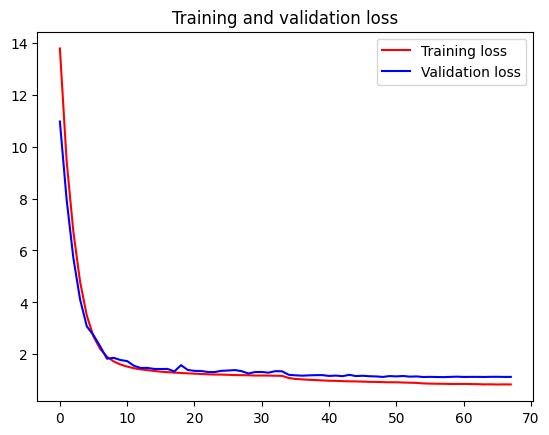

In [17]:
print(model2kerastunner.evaluate(test_generator))

import matplotlib.pyplot as plt
accuracy = HistoryTunner2.history['accuracy']
val_acc = HistoryTunner2.history['val_accuracy']
loss = HistoryTunner2.history['loss']
val_loss = HistoryTunner2.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

In [20]:
model2kerastunner.save('models2DataAugmentation\KerastunnerBalancing2/64batch/best_model_ModelPaper2_ultimo_6786.h5')

# -- With 2 datasets (FER2013 and CK+48) --

In [ ]:
train_dir_FER2013 = 'fer2013/train'
dataset_CK48 = 'CK+48/CK+48'

## Moving the images of FER2013 and CK+48 to concatenatedFERandCK

In [ ]:
os.makedirs('concatenatedFERandCK', exist_ok=True) # Created destination folder

labelscorrects = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise", "anger", "sadness"]

listFilesFER = os.listdir(train_dir_FER2013)
for label in tqdm(listFilesFER): #to each label in the directory FER2013 (train)
    print("Label FER2013: ", label)
    pathlabel = os.path.join(train_dir_FER2013, label)
    listlabels = os.listdir(pathlabel)
    direction = os.path.join('concatenatedFERandCK', label)
    os.makedirs(direction, exist_ok=True)
    for fileinlabel in listlabels: #to each image in FER2013 (train)
        filepath = os.path.join(pathlabel,fileinlabel)
        shutil.copy(filepath, direction) #Copy the images in the destination folder

listFilesCK = os.listdir(dataset_CK48)
for label in tqdm(listFilesCK): #to each label in the directory CK+48
    print("Label CK: ", label)
    pathlabel = os.path.join(dataset_CK48, label)
    listlabels = os.listdir(pathlabel)
    if label in labelscorrects: # If the label is correct
        if label=="anger": # the label can be anger
            direction = os.path.join('concatenatedFERandCK', 'angry')
        elif label=="sadness": # the label can be anger
            direction = os.path.join('concatenatedFERandCK', 'sad')
        else:
            direction = os.path.join('concatenatedFERandCK', label)
        print("LABEL CK+ SI TOMADO", label)
        os.makedirs(direction, exist_ok=True)
        for fileinlabel in listlabels: #to each image in FER2013 (train)
            filepath = os.path.join(pathlabel,fileinlabel)
            shutil.copy(filepath, direction) #Copy the images in the destination folder
    else:
        pass


## Read the new folder

In [ ]:
data_dir = 'concatenatedFERandCK' #define the location of the data folder
filepath = [] #Define the list that will contain all the location of each image
labels = [] #Define th elist that will contain all the labels
classes = os.listdir(data_dir) #Labels list

for classfolder in classes: #For each class
    folderclass = os.path.join(data_dir, classfolder) #Get the path
    file_list = os.listdir(folderclass) #Enter the data into the list
    for files in file_list: #For each file inside the classes
      pathfile = os.path.join(folderclass,files) #Get the path
      filepath.append(pathfile) #Enter the file path in filepath
      labels.append(classfolder) #Enter the file labels in labels



datos = pd.DataFrame({'filepath': filepath, 'labels':labels})
#Create a dataframe with a column called filepath, that will contain the list of image locations
# Create a column called labels, that will contain the list of labels for each file (filepath)

In [ ]:
train_data, val_data = train_test_split(datos, test_size=0.2, stratify=datos['labels'], random_state=42) #Spliting training and validation set


In [12]:
train_data

,filepath,labels
22380,concatenatedFERandCK\sad\Training_2828595.jpg,sad
14009,concatenatedFERandCK\happy\Training_71252302.jpg,happy
12498,concatenatedFERandCK\happy\Training_51753033.jpg,happy
28421,concatenatedFERandCK\surprise\Training_6600577...,surprise
22583,concatenatedFERandCK\sad\Training_32114743.jpg,sad
...,...,...
21192,concatenatedFERandCK\neutral\Training_97875980...,neutral
21743,concatenatedFERandCK\sad\Training_16738287.jpg,sad
2148,concatenatedFERandCK\angry\Training_55459110.jpg,angry
22565,concatenatedFERandCK\sad\Training_31722166.jpg,sad


In [16]:
train_data['labels'].value_counts()

labels
happy       5937
neutral     3972
sad         3931
fear        3338
angry       3304
surprise    2736
disgust      490
Name: count, dtype: int64

## Create the folders of train, test and validation

In [ ]:
output_dir = 'SplitconcatenatedFERandCK'
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')

os.makedirs(train_dir, exist_ok=True) # Create new train folder
os.makedirs(val_dir, exist_ok=True) #Create new validation folder

for classfolder in classes:
    os.makedirs(os.path.join(train_dir, classfolder), exist_ok=True)
    os.makedirs(os.path.join(val_dir, classfolder), exist_ok=True)

for _, row in train_data.iterrows():
    classfolder = row['labels']
    shutil.copy(row['filepath'], os.path.join(train_dir, classfolder)) #Copy each image according to its filepath to the new train directory

for _, row in val_data.iterrows():
    classfolder = row['labels']
    shutil.copy(row['filepath'], os.path.join(val_dir, classfolder)) #Copy each image according to its filepath to the new validation directory



## Read the new folder

In [ ]:
data_dir = 'SplitconcatenatedFERandCK/train' #define the location of the data folder
filepath = [] #Define the list that will contain all the location of each image
labels = [] #Define th elist that will contain all the labels
classes = os.listdir(data_dir) #Labels list

for classfolder in classes: #For each class
    folderclass = os.path.join(data_dir, classfolder) #Get the path
    file_list = os.listdir(folderclass) #Enter the data into the list
    for files in file_list: #For each file inside the classes
      pathfile = os.path.join(folderclass,files) #obtiene la ruta
      filepath.append(pathfile) #Enter the file path in filepath
      labels.append(classfolder) #Enter the file labels in labels



datos = pd.DataFrame({'filepath': filepath, 'labels':labels})

In [15]:
datos['labels'].value_counts()

labels
happy       5937
neutral     3972
sad         3931
fear        3338
angry       3304
surprise    2736
disgust      490
Name: count, dtype: int64

## Balancing the training set with Data Augmention using 5937 images for each class

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


data_dir = 'SplitconcatenatedFERandCK/train'

#The list of classes
classes = os.listdir(data_dir)

# The data is balanced to 5.937 each class
max_images_per_class = 5937

# Slight Data Augmentation parameters for Oversampling
datagen = ImageDataGenerator(
    rotation_range=2,  # rotation range between -2 to 2
    width_shift_range=0.02,  # width shift range 0.02 
    height_shift_range=0.02,  # height shift range 0.02
    zoom_range=0.02,  # zoom range
)

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    num_images = len(os.listdir(class_dir))
    
    #Applying Data augmentation only to minority classes
    if num_images < max_images_per_class: #If the number images in the class is less than 5.937
        print(f"Aplicando Data Augmentation a la clase: {class_name}")
        images_needed = max_images_per_class - num_images
        print(images_needed)

    while len(os.listdir(class_dir)) < max_images_per_class: # To be applied as long as the amount is less than 5.937
        for img_file in os.listdir(class_dir):
            if (len(os.listdir(class_dir)) == max_images_per_class): #if the same, let it come out
                break
            img_path = os.path.join(class_dir, img_file)
            
            #Load the image
            img = load_img(img_path)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)
            
            # Using batches of 1 image, new images are generated with the transformations and saved in the same directory.
            for batch in datagen.flow(x, batch_size=1, save_to_dir=class_dir, save_prefix='aug', save_format='jpg'):
                break

Aplicando Data Augmentation a la clase: angry
2633
Aplicando Data Augmentation a la clase: disgust
5447
Aplicando Data Augmentation a la clase: fear
2599
Aplicando Data Augmentation a la clase: neutral
1965
Aplicando Data Augmentation a la clase: sad
2006
Aplicando Data Augmentation a la clase: surprise
3201


In [18]:
img_shape = 48

## Load the data and apply Data augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = 'SplitconcatenatedFERandCK/train' #new train set
val_dir = 'SplitconcatenatedFERandCK/val' #new val set
test_dir = 'fer2013/test'
img_shape = 48

train_datagen = ImageDataGenerator(
    rescale=1/255,                #Normalization
    rotation_range=8,             #rotation range between -10 to 10 
    zoom_range=0.2,               #zoom range
    width_shift_range=0.1,        
    height_shift_range=0.1,           
    horizontal_flip=True,         
    fill_mode='nearest'                  
)

val_datagen = ImageDataGenerator(
    rescale=1/255
)

test_datagen = ImageDataGenerator(
    rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),   #48x48    
    color_mode='rgb',              # transform to rgb images
    class_mode='categorical',      # apply One Hot Encoder 
    batch_size=64,                 
    seed = 42,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_shape, img_shape),      #48x48 
    color_mode='rgb',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,           
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_shape, img_shape),      #48x48
    color_mode='rgb',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    shuffle=False
)

Found 41559 images belonging to 7 classes.
Found 5928 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
print("Cantidad de imágenes por clase en el conjunto de entrenamiento:") #To show the number of each class
for cls, idx in train_generator.class_indices.items():
    print(f"{cls}: {sum(train_generator.classes == idx)}")

print("\nCantidad de imágenes por clase en el conjunto de validación:")
for cls, idx in val_generator.class_indices.items():
    print(f"{cls}: {sum(val_generator.classes == idx)}")

print("\nCantidad de imágenes por clase en el conjunto de prueba:")
for cls, idx in test_generator.class_indices.items():
    print(f"{cls}: {sum(test_generator.classes == idx)}")

Cantidad de imágenes por clase en el conjunto de entrenamiento:
angry: 5937
disgust: 5937
fear: 5937
happy: 5937
neutral: 5937
sad: 5937
surprise: 5937

Cantidad de imágenes por clase en el conjunto de validación:
angry: 826
disgust: 123
fear: 834
happy: 1485
neutral: 993
sad: 983
surprise: 684

Cantidad de imágenes por clase en el conjunto de prueba:
angry: 958
disgust: 111
fear: 1024
happy: 1774
neutral: 1233
sad: 1247
surprise: 831


## Model 1 CNN 68.75%

In [ ]:
model_MoreData = tf.keras.Sequential([

        
        tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',input_shape=(48,48,3)),
        tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu' ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),

        
        tf.keras.layers.Conv2D(128,(5,5), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=L2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Dense(7, activation='softmax')
    ])


optimiser = tf.keras.optimizers.Adam(learning_rate=1e-4)
model_MoreData.compile(optimizer=optimiser, #The model is created
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_MoreData.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 46, 46, 32)        896       
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 23, 23, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 23, 23, 128)      

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # to stop the model when it stops learning



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/test1_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/test1_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint( #To create a checkpoint when the model is improved
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/test1_MoreData/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/test1_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) #To create a graph that show the accuracy and loss curve


# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


training the model

In [26]:
historytest1_MoreData = model_MoreData.fit(x = train_generator,epochs = 300,validation_data = val_generator, callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
650/650 [==============================] - ETA: 0s - loss: 9.4192 - accuracy: 0.2072
Epoch 1: val_accuracy improved from -inf to 0.26198, saving model to models2DataAugmentation/test1_MoreData/64batch\best_model_ModelPaper2_1_0.2620.h5
650/650 [==============================] - 94s 124ms/step - loss: 9.4192 - accuracy: 0.2072 - val_loss: 8.3549 - val_accuracy: 0.2620 - lr: 1.0000e-04
Epoch 2/300
650/650 [==============================] - ETA: 0s - loss: 7.7079 - accuracy: 0.2632
Epoch 2: val_accuracy improved from 0.26198 to 0.30938, saving model to models2DataAugmentation/test1_MoreData/64batch\best_model_ModelPaper2_2_0.3094.h5
650/650 [==============================] - 76s 116ms/step - loss: 7.7079 - accuracy: 0.2632 - val_loss: 6.7463 - val_accuracy: 0.3094 - lr: 1.0000e-04
Epoch 3/300
650/650 [==============================] - ETA: 0s - loss: 6.1460 - accuracy: 0.3018
Epoch 3: val_accuracy improved from 0.30938 to 0.32608, saving model to models2DataAugmentation/test1_

In [27]:
model_MoreData.evaluate(test_generator)

113/113 [==============================] - 12s 107ms/step - loss: 1.1914 - accuracy: 0.6875


[1.191373586654663, 0.6875174045562744]

In [42]:
model_MoreData.save('models2DataAugmentation/test1_MoreData/64batch/best_model_ModelPaper2_110_0.6875.h5')

In [41]:
model1_load = tf.keras.models.load_model(r'models2DataAugmentation/test1_MoreData/64batch\best_model_ModelPaper2_95_0.7034.h5')
model1_load.evaluate(test_generator)

113/113 [==============================] - 5s 43ms/step - loss: 1.1978 - accuracy: 0.6842


[1.1978379487991333, 0.6841738820075989]

In [9]:
model1_load = tf.keras.models.load_model(r'models2DataAugmentation/test1_MoreData/64batch/best_model_ModelPaper2_110_0.6875.h5')
model1_load.evaluate(test_generator)

113/113 [==============================] - 7s 56ms/step - loss: 1.1914 - accuracy: 0.6875


[1.191373586654663, 0.6875174045562744]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Get all classes of y_test
y_pred = model1_load.predict(test_generator).argmax(axis=1) 

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 5s 42ms/step
              precision    recall  f1-score   support

           0       0.65      0.63      0.64       958
           1       0.89      0.58      0.70       111
           2       0.60      0.43      0.50      1024
           3       0.85      0.90      0.87      1774
           4       0.58      0.74      0.65      1233
           5       0.57      0.55      0.56      1247
           6       0.82      0.77      0.80       831

    accuracy                           0.69      7178
   macro avg       0.71      0.66      0.67      7178
weighted avg       0.69      0.69      0.68      7178

<function confusion_matrix at 0x000001EA8AEDEDD0>


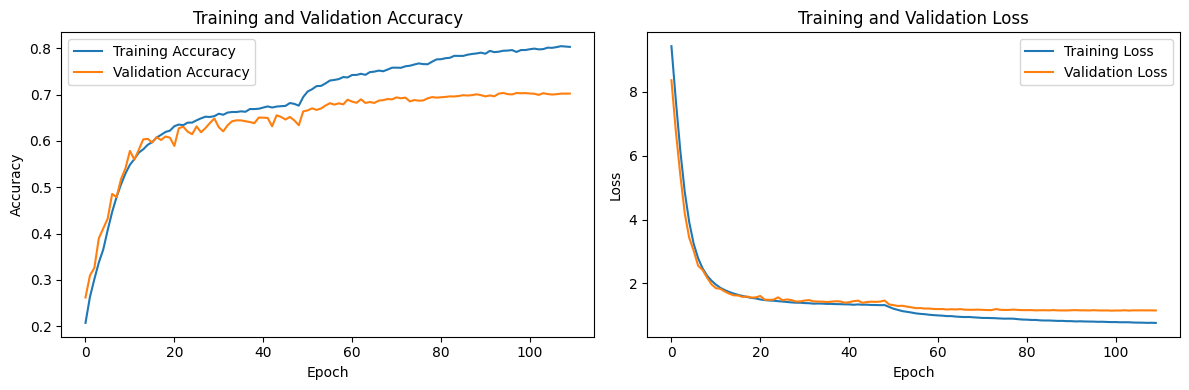

In [28]:
import matplotlib.pyplot as plt


accuracy = historytest1_MoreData.history['accuracy']
loss = historytest1_MoreData.history['loss']
val_accuracy = historytest1_MoreData.history['val_accuracy']
val_loss = historytest1_MoreData.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model 2 CNN 67.45%

In [4]:
model8_MoreData = tf.keras.models.Sequential()   

model8_MoreData.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,3)))
model8_MoreData.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model8_MoreData.add(BatchNormalization())
model8_MoreData.add(MaxPooling2D(2, 2))
model8_MoreData.add(Dropout(0.3))

model8_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData.add(BatchNormalization())
model8_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData.add(Dropout(0.3))

model8_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData.add(BatchNormalization())
model8_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData.add(Dropout(0.3))

model8_MoreData.add(Flatten())
model8_MoreData.add(Dense(1024, activation='relu',kernel_regularizer=L2(0.01)))
model8_MoreData.add(Dropout(0.5))
    
model8_MoreData.add(Dense(7, activation='softmax'))


model8_MoreData.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

model8_MoreData.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

In [30]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/test8_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/test8_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/test8_MoreData/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/test8_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [31]:
historytest8_MoreData = model8_MoreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
650/650 [==============================] - ETA: 0s - loss: 20.5550 - accuracy: 0.2325
Epoch 1: val_accuracy improved from -inf to 0.34447, saving model to models2DataAugmentation/test8_MoreData/64batch\best_model_ModelPaper2_1_0.3445.h5
650/650 [==============================] - 76s 114ms/step - loss: 20.5550 - accuracy: 0.2325 - val_loss: 16.1715 - val_accuracy: 0.3445 - lr: 1.0000e-04
Epoch 2/300
650/650 [==============================] - ETA: 0s - loss: 12.3460 - accuracy: 0.3271
Epoch 2: val_accuracy improved from 0.34447 to 0.36420, saving model to models2DataAugmentation/test8_MoreData/64batch\best_model_ModelPaper2_2_0.3642.h5
650/650 [==============================] - 73s 113ms/step - loss: 12.3460 - accuracy: 0.3271 - val_loss: 9.3104 - val_accuracy: 0.3642 - lr: 1.0000e-04
Epoch 3/300
650/650 [==============================] - ETA: 0s - loss: 7.3833 - accuracy: 0.3758
Epoch 3: val_accuracy improved from 0.36420 to 0.41194, saving model to models2DataAugmentation/t

In [32]:
model8_MoreData.evaluate(test_generator)

113/113 [==============================] - 8s 73ms/step - loss: 1.1018 - accuracy: 0.6711


[1.1017614603042603, 0.6710783243179321]

In [40]:
model8_load = tf.keras.models.load_model(r'models2DataAugmentation/test8_MoreData/64batch\best_model_ModelPaper2_62_0.6847.h5')
model8_load.evaluate(test_generator)

113/113 [==============================] - 5s 44ms/step - loss: 1.1058 - accuracy: 0.6746


[1.1057982444763184, 0.6745611429214478]

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model8_load.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 4s 35ms/step
              precision    recall  f1-score   support

           0       0.62      0.60      0.61       958
           1       0.87      0.50      0.63       111
           2       0.56      0.38      0.45      1024
           3       0.82      0.91      0.86      1774
           4       0.59      0.70      0.64      1233
           5       0.55      0.59      0.57      1247
           6       0.84      0.75      0.79       831

    accuracy                           0.67      7178
   macro avg       0.69      0.63      0.65      7178
weighted avg       0.67      0.67      0.67      7178

<function confusion_matrix at 0x000001EA8AEDEDD0>


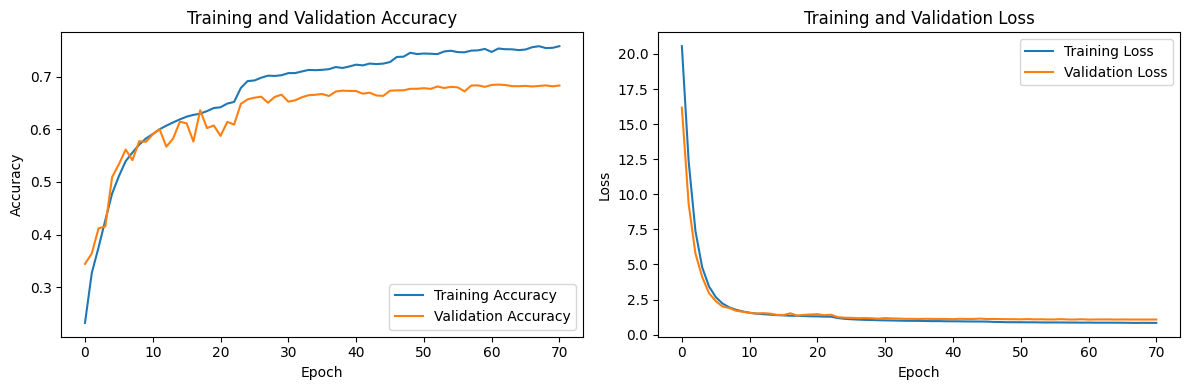

In [33]:
import matplotlib.pyplot as plt


accuracy = historytest8_MoreData.history['accuracy']
loss = historytest8_MoreData.history['loss']
val_accuracy = historytest8_MoreData.history['val_accuracy']
val_loss = historytest8_MoreData.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model 4 66.14%

In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50V2, VGG19
from keras.regularizers import l2
from keras.optimizers import Adamax



input_shape = (48, 48, 3)

base_model = VGG19(include_top=False, weights='imagenet', input_shape=input_shape) #Pre-training model with imagenet weights

model3_MoreData = Sequential([
                    base_model,
                    BatchNormalization(),
                    GlobalAveragePooling2D(),
                    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
                    Dropout(0.4),
                    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
                    Dropout(0.4),
                    Dense(7, activation='softmax')
                  ])

optimizer = Adamax(learning_rate=1e-4) # Adamax optimizer

model3_MoreData.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model3_MoreData.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 batch_normalization_15 (Bat  (None, 1, 1, 512)        2048      
 chNormalization)                                                
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)              

In [35]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/test3_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/test3_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/test3_MoreData/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/test3_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [36]:
historytest3_MoreData = model3_MoreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator,
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
650/650 [==============================] - ETA: 0s - loss: 2.2358 - accuracy: 0.3008
Epoch 1: val_accuracy improved from -inf to 0.31292, saving model to models2DataAugmentation/test3_MoreData/64batch\best_model_ModelPaper2_1_0.3129.h5
650/650 [==============================] - 100s 150ms/step - loss: 2.2358 - accuracy: 0.3008 - val_loss: 2.1079 - val_accuracy: 0.3129 - lr: 1.0000e-04
Epoch 2/300
650/650 [==============================] - ETA: 0s - loss: 1.8827 - accuracy: 0.4409
Epoch 2: val_accuracy improved from 0.31292 to 0.44821, saving model to models2DataAugmentation/test3_MoreData/64batch\best_model_ModelPaper2_2_0.4482.h5
650/650 [==============================] - 96s 148ms/step - loss: 1.8827 - accuracy: 0.4409 - val_loss: 1.7639 - val_accuracy: 0.4482 - lr: 1.0000e-04
Epoch 3/300
650/650 [==============================] - ETA: 0s - loss: 1.6584 - accuracy: 0.5087
Epoch 3: val_accuracy improved from 0.44821 to 0.52328, saving model to models2DataAugmentation/test3

In [38]:
model3_MoreData.evaluate(test_generator)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
113/113 [==============================] - 29s 257ms/step - loss: 1.1404 - accuracy: 0.6471


[1.1404451131820679, 0.6471161842346191]

In [39]:
model3_load = tf.keras.models.load_model(r'models2DataAugmentation/test3_MoreData/64batch\best_model_ModelPaper2_27_0.6704.h5')
model3_load.evaluate(test_generator)

113/113 [==============================] - 6s 47ms/step - loss: 1.2713 - accuracy: 0.6615


[1.271256685256958, 0.661465585231781]

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model3_load.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 5s 43ms/step
              precision    recall  f1-score   support

           0       0.63      0.55      0.58       958
           1       0.87      0.55      0.67       111
           2       0.50      0.50      0.50      1024
           3       0.83      0.89      0.86      1774
           4       0.63      0.58      0.60      1233
           5       0.51      0.58      0.54      1247
           6       0.82      0.76      0.79       831

    accuracy                           0.66      7178
   macro avg       0.68      0.63      0.65      7178
weighted avg       0.66      0.66      0.66      7178

<function confusion_matrix at 0x000001EA8AEDEDD0>


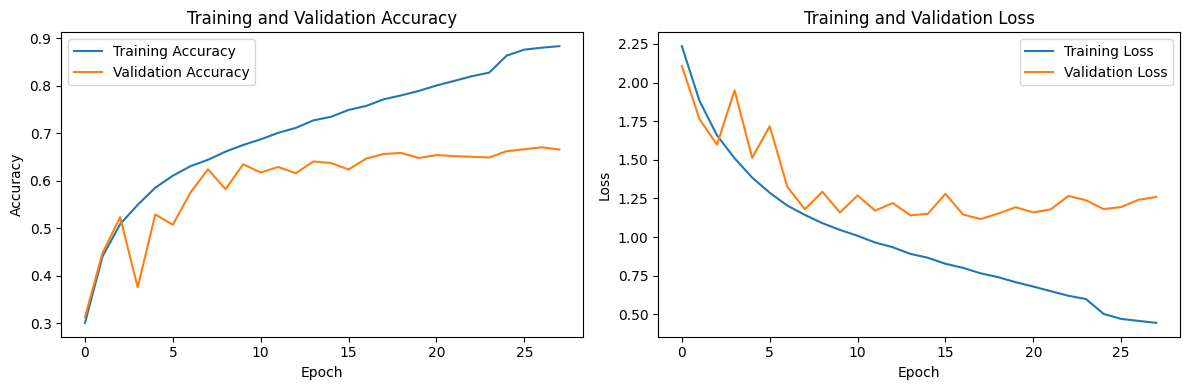

In [37]:
import matplotlib.pyplot as plt


accuracy = historytest3_MoreData.history['accuracy']
loss = historytest3_MoreData.history['loss']
val_accuracy = historytest3_MoreData.history['val_accuracy']
val_loss = historytest3_MoreData.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model Keras tunner 67.63%

- Obtained by Bayesian optimization on models with one dataset

In [6]:
input = tf.keras.layers.Input(shape=(48,48,3))
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(input)
x = Conv2D(288, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.2)(x)

x = Conv2D(160, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = Conv2D(160, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.4)(x)

x = Conv2D(288, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.2)(x)

x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = Conv2D(224, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.4)(x)

#x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
#x = Conv2D(160, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
#x = BatchNormalization()(x)
#x = MaxPooling2D(2,2)(x)
#x = Dropout(0.4)(x)


x = tf.keras.layers.Flatten()(x)
x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
x = Dropout(0.5)(x)
output_layer = Dense(7, activation="softmax")(x)

modelTunner = tf.keras.models.Model(inputs=input, outputs=output_layer)

modelTunner.compile(optimizer=Adam(1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

modelTunner.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 288)       166176    
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 288)      1152      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 288)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 288)       0     

In [7]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/ModelKerasTunner/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/ModelKerasTunner/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/ModelKerasTunner/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/ModelKerasTunner/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [8]:
HistoryTunner = modelTunner.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
650/650 [==============================] - ETA: 0s - loss: 24.3747 - accuracy: 0.2046
Epoch 1: val_accuracy improved from -inf to 0.25692, saving model to models2DataAugmentation/ModelKerasTunner/64batch\best_model_ModelPaper2_1_0.2569.h5
650/650 [==============================] - 228s 342ms/step - loss: 24.3747 - accuracy: 0.2046 - val_loss: 21.1098 - val_accuracy: 0.2569 - lr: 1.0000e-04
Epoch 2/300
650/650 [==============================] - ETA: 0s - loss: 16.5921 - accuracy: 0.2880
Epoch 2: val_accuracy improved from 0.25692 to 0.29453, saving model to models2DataAugmentation/ModelKerasTunner/64batch\best_model_ModelPaper2_2_0.2945.h5
650/650 [==============================] - 103s 158ms/step - loss: 16.5921 - accuracy: 0.2880 - val_loss: 13.6245 - val_accuracy: 0.2945 - lr: 1.0000e-04
Epoch 3/300
650/650 [==============================] - ETA: 0s - loss: 11.0400 - accuracy: 0.3462
Epoch 3: val_accuracy improved from 0.29453 to 0.33468, saving model to models2DataAugmen

In [10]:
modelTunner.evaluate(test_generator)

113/113 [==============================] - 13s 115ms/step - loss: 1.1478 - accuracy: 0.6764


[1.1478469371795654, 0.676372230052948]

In [13]:
modelTunner.save("models2DataAugmentation/ModelKerasTunner/64batch/best_model_ModelPaper2_71_0.6763.h5")

In [11]:
modelTunner_load = tf.keras.models.load_model(r'models2DataAugmentation/ModelKerasTunner/64batch\best_model_ModelPaper2_66_0.6871.h5')
modelTunner_load.evaluate(test_generator)

113/113 [==============================] - 6s 48ms/step - loss: 1.1611 - accuracy: 0.6733


[1.161085844039917, 0.6733072996139526]

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = modelTunner.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 5s 46ms/step
              precision    recall  f1-score   support

           0       0.60      0.63      0.61       958
           1       0.89      0.53      0.67       111
           2       0.54      0.40      0.46      1024
           3       0.84      0.90      0.87      1774
           4       0.59      0.71      0.65      1233
           5       0.56      0.55      0.55      1247
           6       0.83      0.74      0.79       831

    accuracy                           0.68      7178
   macro avg       0.69      0.64      0.66      7178
weighted avg       0.67      0.68      0.67      7178

<function confusion_matrix at 0x000001B9855DAD40>


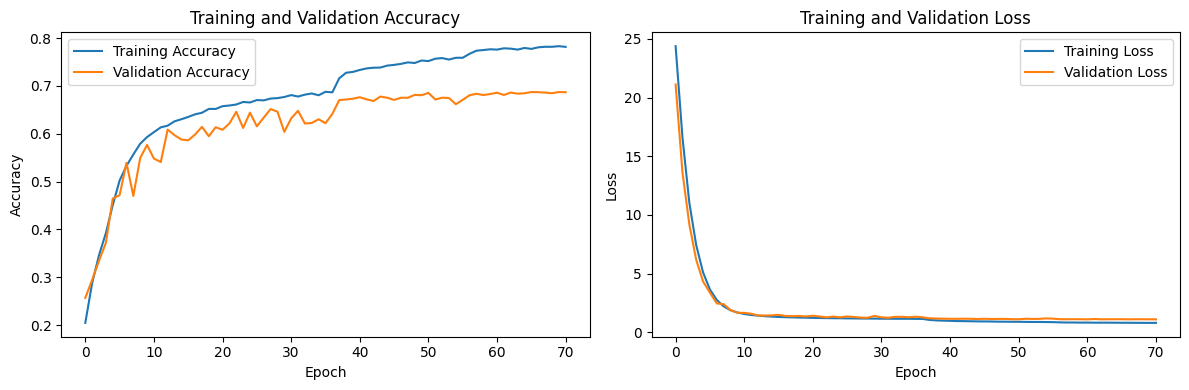

In [9]:
import matplotlib.pyplot as plt


accuracy = HistoryTunner.history['accuracy']
loss = HistoryTunner.history['loss']
val_accuracy = HistoryTunner.history['val_accuracy']
val_loss = HistoryTunner.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()